In [1]:
import ray
ray.init()

2022-12-14 13:58:56,623	INFO worker.py:1538 -- Started a local Ray instance.


Python version:,3.8.12
Ray version:,2.2.0


In [2]:
%run ./functions_gandalf_skywalker_20210822.ipynb
%run ./engine_gandalf_skywalker_20220106.py
%run ./Genera_LIB_V5.ipynb

5.3.1


In [3]:
def carica_storico(file_name,uct_offset,type_session,resample_tf,IS,OOS,custom_session_start,custom_session_stop,noise,pct_noise):
    import os
    import talib as ta
    
    os.chdir(dir_history)
    data = load_data_intraday_fast(file_name)  
    print("Caricato storico")
    data = data.sort_index(ascending=True)
    data.index = data.index.tz_localize('Etc/Zulu')
    data.index = data.index.tz_convert(uct_offset )
    data.index = data.index.tz_localize(None)
    data = data[data!=0]
    #data = data.fillna(method="ffill")
    data = data.iloc[1:-1]
    print("Resample dei dati")
    if type_session == 1:
        dataset=resample_custom_session("5min",resample_tf ,data,custom_session_start,custom_session_stop) 
    if type_session == 0:    
        dataset=resample_standard_session("5min",resample_tf,data)
        
    if noise == 1:
        print("AGGIUNGO RUMORE")
        dataset=add_noise(dataset.open, dataset.high, dataset.low, dataset.close,dataset.volume, pct_noise)

    dataset = dataset.loc[IS:OOS]
    dataset["dayofweek"] = dataset.index.dayofweek
    dataset["day"] = dataset.index.day
    dataset["month"] = dataset.index.month
    dataset["year"] = dataset.index.year
    dataset["dayofyear"] = dataset.index.dayofyear
    dataset["week"] = dataset.index.week
    dataset["hour"] = dataset.index.hour
    dataset["minute"] = dataset.index.minute
    dataset["daily_open"] = daily_open(dataset,1)
    dataset["daily_high"] = daily_high(dataset,1)
    dataset["daily_low"] = daily_low(dataset,1)
    dataset["daily_close"] = daily_close(dataset,1)
    dataset["AVGPRICE"]=ta.AVGPRICE(dataset.open, dataset.high, dataset.low, dataset.close)
    dataset["MEDPRICE"]=ta.MEDPRICE(dataset.high, dataset.low)
    dataset["TYPPRICE"]=ta.TYPPRICE(dataset.high, dataset.low, dataset.close)
    dataset["WCLPRICE"]=ta.WCLPRICE(dataset.high, dataset.low, dataset.close)
    history=dataset.copy()
    
    print("Carico indicatori")

    
    import legitindicators

    """data_filter=dataset.iloc[:].copy()
    for e in data_filter.columns:
        data_filter[e]= legitindicators.super_smoother(data_filter[e], 10)"""
    
    #import talib as ta
    #ATR = ta.ATR(dataset.high,dataset.low,dataset.close,5)
    #ATR = ATR.fillna(0)
    #dataATR=dataset.copy()
    #for e in dataATR.columns:
        #dataATR[e]=dataATR[e]/ATR
        
    applica_indicatori=apply_indicator(dataset)
    dataset=applica_indicatori[0]
    dataset_ind = dataset.iloc[:,21:].copy()


    rules=dataset.iloc[:,21:].T.values
    rule_formulas=np.arange(len(rules))
    
    history.tail(10)
    
    history.close.plot(figsize=(20,10),title=SIMBOLO+"_"+RESAMPLE_TF)
    print("Fatto")
    return dataset , dataset_ind , history , rules, rule_formulas

In [4]:

def get_basic_bands(med_price, atr, multiplier):
    matr = multiplier * atr
    upper = med_price + matr
    lower = med_price - matr
    return upper, lower


from numba import njit
@njit
def get_final_bands_nb(close, upper, lower):
    trend = np.full(close.shape, np.nan)
    dir_ = np.full(close.shape, 1)
    long = np.full(close.shape, np.nan)
    short = np.full(close.shape, np.nan)

    for i in range(1, close.shape[0]):
        if close[i] > upper[i - 1]:
            dir_[i] = 1
        elif close[i] < lower[i - 1]:
            dir_[i] = -1
        else:
            dir_[i] = dir_[i - 1]
            if dir_[i] > 0 and lower[i] < lower[i - 1]:
                lower[i] = lower[i - 1]
            if dir_[i] < 0 and upper[i] > upper[i - 1]:
                upper[i] = upper[i - 1]

        if dir_[i] > 0:
            trend[i] = long[i] = lower[i]
        else:
            trend[i] = short[i] = upper[i]

    return trend, dir_, long, short


import talib
def faster_supertrend_talib(high, low, close, period=7, multiplier=3):
    avg_price = talib.MEDPRICE(high, low)
    atr = talib.ATR(high, low, close, period)
    upper, lower = get_basic_bands(avg_price, atr, multiplier)
    return get_final_bands_nb(close, upper, lower)

In [242]:
def apply_indicator(history):

    import random


    MIN_PERIOD = 5
    MAX_PERIOD = 200
    MAX_LOOKBACK = 5
    MIN_DEVIATION = 0.5
    MAX_DEVIATION = 3
    DATASET = history.iloc[:,:5]

    PRICE_LIST= ["OPEN","HIGH","LOW","CLOSE","AvgPrice","MedPrice","MedBodyPrice"]

    atr_list=[]
    for e in range(10000):
        DATAFRAME = DATASET 
        PERIOD = random.randrange(MIN_PERIOD , MAX_PERIOD, 1)
        SHIFT = random.randrange(1 , MAX_LOOKBACK, 1)
        atr_list.append(eval('"avg_true_range(DATAFRAME,"+str(PERIOD)+").shift("+str(SHIFT)+")"'))   
    atr_rules=[]
    for e in range(10000):
        atr_rules.append(random.choice(atr_list)+random.choice(["<",">"])+random.choice(atr_list))

    rsi_list=[]
    for e in range(10000):
        DATAFRAME = DATASET 
        PERIOD = random.randrange(MIN_PERIOD , MAX_PERIOD, 1)
        SHIFT = random.randrange(1 , MAX_LOOKBACK, 1)
        TMP_PRICE_NAME = random.choice(PRICE_LIST)
        rsi_list.append(eval('"RSI("+TMP_PRICE_NAME+"(DATAFRAME),"+str(PERIOD)+").shift("+str(SHIFT)+")"'))   
    rsi_rules=[]
    for e in range(10000):
        if random.randrange(0, 2, 1) == 0:
            rsi_rules.append(random.choice(rsi_list)+random.choice(["<",">"])+random.choice(rsi_list))
        else:
            rsi_rules.append(random.choice(rsi_list)+random.choice(["<",">"])+str(random.randrange(1 , 100, 1)))

    mfi_list=[]
    for e in range(10000):
        DATAFRAME = DATASET 
        PERIOD = random.randrange(MIN_PERIOD , MAX_PERIOD, 1)
        SHIFT = random.randrange(1 , MAX_LOOKBACK, 1)
        mfi_list.append(eval('"MFI(DATAFRAME,"+str(PERIOD)+").shift("+str(SHIFT)+")"')) 
    mfi_rules=[]
    for e in range(10000):
        if random.randrange(0, 2, 1) == 0:
            mfi_rules.append(random.choice(mfi_list)+random.choice(["<",">"])+random.choice(mfi_list))
        else:
            mfi_rules.append(random.choice(mfi_list)+random.choice(["<",">"])+str(random.randrange(20 , 80, 1)))   

    bb_list=[]
    for e in range(10000):
        DATAFRAME = DATASET 
        PERIOD = random.randrange(MIN_PERIOD , MAX_PERIOD, 1)
        SHIFT = random.randrange(1 , MAX_LOOKBACK, 1)
        DEVIATION = round(random.uniform(MIN_DEVIATION, MAX_DEVIATION),1)
        TMP_PRICE_NAME = random.choice(PRICE_LIST)
        UPPER_LOWER = random.randrange(0, 2, 1)
        bb_list.append(eval('"BollingerBand("+TMP_PRICE_NAME+"(DATAFRAME),"+str(PERIOD)+","+str(DEVIATION)+","+str(UPPER_LOWER)+").shift("+str(SHIFT)+")"')) 
    bb_rules=[]
    for e in range(10000):
        if random.randrange(0, 2, 1) == 0:
            bb_rules.append(random.choice(bb_list)+random.choice(["<",">"])+random.choice(bb_list))
        else:
            TMP_PRICE_NAME = random.choice(PRICE_LIST)
            SHIFT = random.randrange(1 , MAX_LOOKBACK, 1)
            DATAFRAME = DATASET
            str_PRICE = TMP_PRICE_NAME+"(DATAFRAME).shift("+str(SHIFT)+")"
            bb_rules.append(random.choice(bb_list)+random.choice(["<",">"])+str_PRICE)       

    roc_list=[]
    for e in range(10000):
        DATAFRAME = DATASET 
        PERIOD = random.randrange(MIN_PERIOD , MAX_PERIOD, 1)
        SHIFT = random.randrange(1 , MAX_LOOKBACK, 1)
        TMP_PRICE_NAME = random.choice(PRICE_LIST)
        roc_list.append(eval('"ROC("+TMP_PRICE_NAME+"(DATAFRAME),"+str(PERIOD)+").shift("+str(SHIFT)+")"'))  
    roc_rules=[]
    for e in range(1000):
        if random.randrange(0, 2, 1) == 0:
            roc_rules.append(random.choice(roc_list)+random.choice(["<",">"])+random.choice(roc_list))
        else:
            roc_rules.append(random.choice(roc_list)+random.choice(["<",">"])+str(random.randrange(-10 , 10, 1)))


    mom_list=[]
    for e in range(10000):
        DATAFRAME = DATASET 
        PERIOD = random.randrange(MIN_PERIOD , MAX_PERIOD, 1)
        SHIFT = random.randrange(1 , MAX_LOOKBACK, 1)
        TMP_PRICE_NAME = random.choice(PRICE_LIST)
        mom_list.append(eval('"Momentum("+TMP_PRICE_NAME+"(DATAFRAME),"+str(PERIOD)+").shift("+str(SHIFT)+")"'))  
    mom_rules=[]
    for e in range(10000):
        if random.randrange(0, 2, 1) == 0:
            mom_rules.append(random.choice(mom_list)+random.choice(["<",">"])+random.choice(mom_list))
        else:
            mom_rules.append(random.choice(mom_list)+random.choice(["<",">"])+str(random.randrange(-10 , 10, 1))) 

    sma_list=[]
    for e in range(10000):
        DATAFRAME = DATASET 
        PERIOD = random.randrange(MIN_PERIOD , MAX_PERIOD, 1)
        SHIFT = random.randrange(1 , MAX_LOOKBACK, 1)
        TMP_PRICE_NAME = random.choice(PRICE_LIST)
        sma_list.append(eval('"SMA("+TMP_PRICE_NAME+"(DATAFRAME),"+str(PERIOD)+").shift("+str(SHIFT)+")"')) 
    sma_rules=[]
    for e in range(10000):
        if random.randrange(0, 2, 1) == 0:
            sma_rules.append(random.choice(sma_list)+random.choice(["<",">"])+random.choice(sma_list))
        else:
            TMP_PRICE_NAME = random.choice(PRICE_LIST)
            SHIFT = random.randrange(1 , MAX_LOOKBACK, 1)
            DATAFRAME = DATASET
            str_PRICE = TMP_PRICE_NAME+"(DATAFRAME).shift("+str(SHIFT)+")"
            sma_rules.append(random.choice(sma_list)+random.choice(["<",">"])+str_PRICE)     

    adx_list=[]
    for e in range(10000):
        DATAFRAME = DATASET 
        PERIOD = random.randrange(MIN_PERIOD , MAX_PERIOD, 1)
        SHIFT = random.randrange(1 , MAX_LOOKBACK, 1)
        adx_list.append(eval('"adx(DATAFRAME,"+str(PERIOD)+").shift("+str(SHIFT)+")"')) 
    adx_rules=[]
    for e in range(10000):
        adx_rules.append(random.choice(adx_list)+random.choice(["<",">"])+random.choice(adx_list))

    trix_list=[]
    for e in range(10000):
        DATAFRAME = DATASET 
        PERIOD = random.randrange(MIN_PERIOD , MAX_PERIOD, 1)
        trix_list.append(eval('"trix(DATAFRAME,"+str(PERIOD)+").shift("+str(SHIFT)+")"'))   
    trix_rules=[]
    for e in range(10000):
        if random.randrange(0, 2, 1) == 0:
            trix_rules.append(random.choice(trix_list)+random.choice(["<",">"])+random.choice(trix_list))
        else:
            TMP_PRICE_NAME = random.choice(PRICE_LIST)
            SHIFT = random.randrange(1 , MAX_LOOKBACK, 1)
            DATAFRAME = DATASET
            str_PRICE = TMP_PRICE_NAME+"(DATAFRAME).shift("+str(SHIFT)+")"
            trix_rules.append(random.choice(trix_list)+random.choice(["<",">"])+str_PRICE)     
            
    range_rules=[]
    for e in range(10000):
        DATAFRAME = DATASET 
        SHIFT = random.randrange(1 , MAX_LOOKBACK, 1)
        MOLTI = randrange_float(0.25, 5, 0.25)
        range_rules.append(eval('"Range(DATAFRAME).shift(1)"+random.choice(["<",">"])+"(Range(DATAFRAME).shift("+str(SHIFT)+")*"+str(MOLTI)+")"'))
            

    lista_rules=[]
    lista_indicatori=[atr_rules,rsi_rules,mfi_rules,bb_rules,roc_rules,mom_rules,sma_rules,adx_rules,trix_rules,range_rules]
    for e in lista_indicatori:
        x=random.choices(e,k=100)
        lista_rules=lista_rules+x
    
    for e in tqdm(lista_rules):
        tmp_check=eval(e)
        history[e]=tmp_check
        
    return history , history.columns.to_list()


In [11]:
def apply_indicator(history):

    import random


    MIN_PERIOD = 5
    MAX_PERIOD = 200
    MAX_LOOKBACK = 5
    MIN_DEVIATION = 0.5
    MAX_DEVIATION = 3
    DATASET = history.iloc[:,:5]

    PRICE_LIST= ["OPEN","HIGH","LOW","CLOSE","AvgPrice","MedPrice","MedBodyPrice"]
    
    range_rules=[]
    for e in range(10000):
        DATAFRAME = DATASET
        SHIFT = random.randrange(1 , MAX_LOOKBACK, 1)
        MOLTI = round(random.uniform(0.25, 5), 1)
        range_rules.append(eval('"Range(DATAFRAME).shift(1)"+random.choice(["<",">"])+"(Range(DATAFRAME).shift("+str(SHIFT)+")*"+str(MOLTI)+")"'))
            

    body_rules=[]
    for e in range(10000):
        DATAFRAME = DATASET
        SHIFT = random.randrange(1 , MAX_LOOKBACK, 1)
        MOLTI = round(random.uniform(0.25, 5), 1)
        body_rules.append(eval('"Body(DATAFRAME).shift(1)"+random.choice(["<",">"])+"(Body(DATAFRAME).shift("+str(SHIFT)+")*"+str(MOLTI)+")"'))
        
    body_range_rules=[]
    for e in range(10000):
        DATAFRAME = DATASET
        SHIFT = random.randrange(1 , MAX_LOOKBACK, 1)
        SHIFT1 = random.randrange(1 , MAX_LOOKBACK, 1)
        MOLTI = round(random.uniform(0.25, 5), 1)
        body_range_rules.append(eval('"Range(DATAFRAME).shift("+str(SHIFT)+")"+random.choice(["<",">"])+"(Body(DATAFRAME).shift("+str(SHIFT1)+")*"+str(MOLTI)+")"'))
        
    High_Close_rules=[]
    for e in range(10000):
        DATAFRAME = DATASET
        SHIFT = random.randrange(1 , MAX_LOOKBACK, 1)
        MOLTI = round(random.uniform(0.25, 5), 1)
        High_Close_rules.append(eval('"High_Close(DATAFRAME).shift(1)"+random.choice(["<",">"])+"(High_Close(DATAFRAME).shift("+str(SHIFT)+")*"+str(MOLTI)+")"'))
    
    
    High_Open_rules=[]
    for e in range(10000):
        DATAFRAME = DATASET
        SHIFT = random.randrange(1 , MAX_LOOKBACK, 1)
        MOLTI = round(random.uniform(0.25, 5), 1)
        High_Open_rules.append(eval('"High_Open(DATAFRAME).shift(1)"+random.choice(["<",">"])+"(High_Open(DATAFRAME).shift("+str(SHIFT)+")*"+str(MOLTI)+")"'))
        
    Low_Close_rules=[]
    for e in range(10000):
        DATAFRAME = DATASET
        SHIFT = random.randrange(1 , MAX_LOOKBACK, 1)
        MOLTI = round(random.uniform(0.25, 5), 1)
        Low_Close_rules.append(eval('"Low_Close(DATAFRAME).shift(1)"+random.choice(["<",">"])+"(Low_Close(DATAFRAME).shift("+str(SHIFT)+")*"+str(MOLTI)+")"'))
    
    Low_Open_rules=[]
    for e in range(10000):
        DATAFRAME = DATASET
        SHIFT = random.randrange(1 , MAX_LOOKBACK, 1)
        MOLTI = round(random.uniform(0.25, 5), 1)
        Low_Open_rules.append(eval('"Low_Open(DATAFRAME).shift(1)"+random.choice(["<",">"])+"(Low_Open(DATAFRAME).shift("+str(SHIFT)+")*"+str(MOLTI)+")"'))
            
    lista_rules=[]
    lista_indicatori=[range_rules,body_rules,body_range_rules,High_Close_rules, High_Open_rules,Low_Close_rules,Low_Open_rules]
    for e in lista_indicatori:
        x=random.choices(e,k=1000)
        lista_rules=lista_rules+x
    
    for e in tqdm(lista_rules):
        tmp_check=eval(e)
        history[e]=tmp_check
        
    return history , history.columns.to_list()

In [119]:
def randrange_float(start, stop, step):
    return random.randint(0, int((stop - start) / step)) * step + start

def apply_indicator(history):

    import random


    MAX_LOOKBACK = 5
    DATASET = history.iloc[:,:5]

    log_price=["OpenToLowLog",
    "OpenToAvgPriceLog",
    "OpenToMedPriceLog",
    "OpenToOpenLog",
    "OpenToMedBodyPriceLog",
    "CloseToMedPriceLog",
    "CloseToCloseLog",
    "CloseToLowLog",
    "CloseToAvgPriceLog",
    "CloseToMedBodyPriceLog",
    "HighToCloseLog",
    "HighToOpenLog",
    "HighToMedBodyPriceLog",
    "HighToMedPriceLog",
    "HighToAvgPriceLog",
    "HighToHighLog",
    "LowToLowLog",
    "AvgPriceToMedPriceLog",
    "AvgPriceToLowLog",
    "AvgPriceToAvgPriceLog",
    "AvgPriceToMedBodyPriceLog",
    "MedPriceToLowLog",
    "MedBodyPriceToLowLog",
    "MedPriceToMedBodyPriceLog",
    "MedPriceToMedPriceLog",
    "MedBodyPriceToMedBodyPriceLog",
    "RangeLog",
    "BodyLog",
    "BodyToRangeLog"]

    lista_rules=[]


    for e0 in range(10000):
        DATAFRAME = DATASET
        SHIFT = random.randrange(2 , MAX_LOOKBACK, 1)
        log_name=random.choices(log_price)[0]
        log_name2=random.choices(log_price)[0]
        MOLTI=randrange_float(0.5 ,5 ,0.5)
        lista_rules.append(eval('"'+log_name+'(DATAFRAME).shift(1)"+random.choice(["<",">"])+"('+log_name+'(DATAFRAME).shift("+str(SHIFT)+")*"+str(MOLTI)+")"'))
    lista_rules=list(set(lista_rules))
    for e in tqdm(lista_rules):
        tmp_check=eval(e)
        history[e]=tmp_check
    
    return history , history.columns.to_list()

def eval_pattern(ptn):
    for e in ptn:
        exec(e,dataset)

####################### pattern

def apply_indicator(dataset):

    dataset=dataset.copy()
    
    ptn=pattern_translator()

    for e in tqdm(range(1,len(ptn))):
        for r in ptn["p"+str(e)]:
            exec(r)
        
    return dataset , dataset.columns

In [6]:
dir_home=(r"C:\Users\Drako\Genetico_V3")
dir_history=(r"C:\Users\Drako\TS_API")

In [7]:
def info_simboli():
    import os
    import numpy as np
    import pandas as pd

    valori=pd.read_csv("Markets_Specifications_Live.csv",sep=",",encoding='cp1252')
    valori.reset_index(inplace=True)
    valori.Exchange_Time=np.where(valori.Exchange_Time==-6,"CST6CDT",valori.Exchange_Time)
    valori.Exchange_Time=np.where(valori.Exchange_Time=="-5","EST5EDT",valori.Exchange_Time)
    valori.Exchange_Time=np.where(valori.Exchange_Time=="1","CET",valori.Exchange_Time)
    valori["Simbolo"]=valori.Physical
    print("Calcolo Min Avg Trade per mercato...")
    ls_lp , ls_std = last_price_std(valori)
    valori["Last_Price"] = ls_lp
    valori["Standard_Deviation"] = ls_std 
    valori["Min_Avg_Trade"] = (valori.BigPointValue*valori.Last_Price)
    valori["Min_Avg_Trade"] = (valori["Min_Avg_Trade"]*0.0006).round()  ##### delta x modificare min avg trade
    valori=valori[(valori.Physical!="KC")&(valori.Physical!="TY")]
    return valori


os.chdir(dir_home)
valori=info_simboli()

valori

Calcolo Min Avg Trade per mercato...


  0%|          | 0/27 [00:00<?, ?it/s]

,index,SecurityName,Exchange Code,Physical,Underlying Future,MarketTypeName,Exchange,BigPointValue,Unit,Margins,...,Custom Close,Tick,Cost,AMP_simb,Exchange_Time,TT_Code,Simbolo,Last_Price,Standard_Deviation,Min_Avg_Trade
0,0,Australian Dollar,6A,AD,Australian Dollar,Currencies,CME,100000,0.00,2000,...,1400,0.000100,25,DA6,CST6CDT,6A,AD,0.67405,0.089246,40.0
1,1,British Pound,6B,BP,British Pound,Currencies,CME,62500,0.00,2500,...,1400,0.000100,25,BP6,CST6CDT,6B,BP,1.19130,0.158153,45.0
2,2,Crude Oil,CL,CL,Crude Oil,Energies,CME,1000,0.10,6000,...,1430,0.010000,50,CLE,EST5EDT,CL,CL,102.83000,29.720852,62.0
3,3,Euro FX,6E,EC,Euro FX,Currencies,CME,125000,0.00,3000,...,1400,0.000100,25,EU6,CST6CDT,6E,EC,1.00940,0.125934,76.0
4,4,E-mini S&P 500,ES,ES,E-mini S&P 500,Stock Indices,CME,50,0.10,12000,...,1515,0.250000,25,EP,CST6CDT,ES,ES,3858.00000,944.833453,116.0
5,5,DAX Futures,FDAX,FDAX,DAX Futures,Stock Indices,EUREX,25,0.20,30000,...,2200,0.500000,50,FDX,CET,FDAX,FDAX,12824.00000,2503.541585,192.0
6,6,EURO STOXX 50 Index,FESX,FESX,EURO STOXX 50 Index,Stock Indices,EUREX,5,0.00,3000,...,2200,0.500000,20,DSX,CET,FESX,FESX,3460.00000,795.870558,10.0
7,7,Euro Bund,FGBL,FGBL,Euro Bund,Fixed Income,EUREX,1000,0.00,2400,...,2200,0.010000,20,DB,CET,FGBL,FGBL,151.27000,21.008999,91.0
8,8,Gold,GC,GC,Gold,Metals,CME,100,0.10,8500,...,1500,0.100000,60,GCE,EST5EDT,GC,GC,1731.90000,210.684785,104.0
9,9,Copper,HG,HG,Copper,Metals,CME,25000,0.00,7500,...,1500,0.050000,60,CPE,EST5EDT,HG,HG,3.42500,0.616178,51.0


# Carico Dati e Indicatori STANDARD

Caricato storico
Resample dei dati
Carico indicatori


  0%|          | 0/1737 [00:00<?, ?it/s]

Fatto


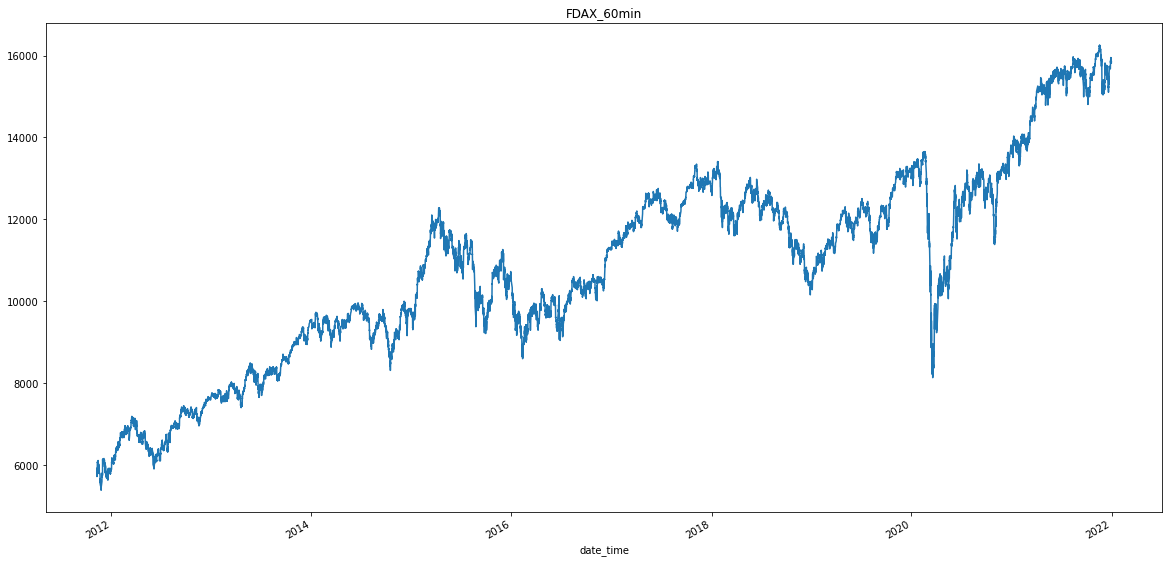

In [120]:

SIMBOLO = "FDAX"

TYPE_SESSION = 1    
RESAMPLE_TF = "60min"  ### RESAMPLE POSSIBILI "5min","15min","30min","60min","120min","240min","480min","1380min","1440min"]
START_DATE = "2010-01-01"
END_DATE = "2022-01-01"


dataset , dataset_ind , history , rules, rule_formulas , bigpointvalue , tick , utc_offset , custom_session_start ,\
custom_session_stop , costi = environment(SIMBOLO,TYPE_SESSION,RESAMPLE_TF,START_DATE,END_DATE)

In [121]:
def target(direzione,_search,dataset):

    price=dataset.open.copy()
    t_m=[]
    t_m=price.shift(-_search)-price
    t_m=t_m.shift(-1)
    t_m=t_m.fillna(0)
    if direzione == "long":
        t_m=np.array(t_m * bigpointvalue)
    else:
        t_m=t_m*(-1)
        t_m=np.array(t_m * bigpointvalue)
    return t_m

In [122]:
backup=dataset_ind.copy()

In [123]:
rules=backup.copy().values

In [124]:
len(history)//5

7155

In [125]:
OOS = 5000 #barre
dataset_ind=backup.copy()

In [126]:
from pandas import read_csv
from numpy import set_printoptions
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif


for k in range(1,24):

    EXIT = k
    DIREZIONE = "long"
    tg=target(DIREZIONE,EXIT,history.iloc[:-OOS])
    tg=pd.Series(index=history.iloc[:-OOS].index,data=tg)
    tg=tg.fillna(0)
    Y=tg
    Y=np.where(Y<-500,-1,Y)
    Y=np.where(Y>500,1,Y)
    Y=np.where((Y!=1)&(Y!=-1),0,Y)
    Xx=dataset_ind.iloc[:-OOS].values

    # Feature Selection with Univariate Statistical Tests

    # load data

    test = SelectKBest(score_func=f_classif, k=4)
    fit = test.fit(Xx, Y)
    # summarize scores
    set_printoptions(precision=3)
    #print(fit.scores_)
    fi=pd.Series(fit.scores_)
    fi=fi.sort_values(ascending=False)
    print("")
    print("USCITA A:",k,"BARRE")
    
    display(fi.head())


USCITA A: 1 BARRE


1093    38.443058
1539    37.553062
428     36.985390
1356    36.891907
1230    36.518356
dtype: float32


USCITA A: 2 BARRE


1231    53.848248
931     53.848248
539     53.848248
451     53.437458
183     53.437458
dtype: float32


USCITA A: 3 BARRE


1231    48.085869
539     48.085869
931     48.085869
183     47.928806
451     47.928806
dtype: float32


USCITA A: 4 BARRE


635     12.850721
619     12.826145
801     11.629474
1204    11.549049
174     10.525782
dtype: float32


USCITA A: 5 BARRE


1130    8.095995
905     8.041122
1692    7.987863
1005    7.927097
838     7.527588
dtype: float32


USCITA A: 6 BARRE


174     13.015514
548     12.713952
677     12.598663
1487    12.035233
1543    11.650142
dtype: float32


USCITA A: 7 BARRE


1250    7.036248
106     6.959106
174     6.864448
677     6.709144
548     6.569454
dtype: float32


USCITA A: 8 BARRE


747     5.755720
850     5.741763
1250    5.257340
106     5.222388
655     4.854788
dtype: float32


USCITA A: 9 BARRE


445     9.776902
540     9.574153
1250    9.528962
516     9.454449
106     9.324008
dtype: float32


USCITA A: 10 BARRE


1415    6.971988
747     6.941057
516     6.833417
174     6.825006
46      6.758796
dtype: float32


USCITA A: 11 BARRE


1415    9.870202
1119    9.255345
174     8.679646
901     8.605961
1487    7.866751
dtype: float32


USCITA A: 12 BARRE


1655    6.517213
323     6.346233
901     5.992322
548     5.724303
677     5.624455
dtype: float32


USCITA A: 13 BARRE


548     9.852650
677     9.697932
174     9.443843
1487    8.790650
1119    8.400173
dtype: float32


USCITA A: 14 BARRE


1119    8.382203
677     7.861367
1415    7.561663
174     7.399748
1487    7.298588
dtype: float32


USCITA A: 15 BARRE


1415    7.299074
1119    6.120698
547     5.294159
1557    5.129767
723     4.997587
dtype: float32


USCITA A: 16 BARRE


1415    5.584621
1316    5.372341
1119    5.138966
1625    4.990615
1388    4.864734
dtype: float32


USCITA A: 17 BARRE


1415    11.304405
1119    10.211032
1316     8.896349
659      8.163215
1492     8.011200
dtype: float32


USCITA A: 18 BARRE


1119    6.802986
1415    6.545255
82      6.434858
1258    6.327874
122     6.055646
dtype: float32


USCITA A: 19 BARRE


1316    11.744498
1119    11.541222
1415    10.867309
1727     8.905245
667      7.995286
dtype: float32


USCITA A: 20 BARRE


1316    17.303345
1415    14.942108
1119    14.904449
1727    11.953995
667     10.170243
dtype: float32


USCITA A: 21 BARRE


1316    17.142441
1119    15.557798
1415    14.625078
1727    11.664515
667     11.526992
dtype: float32


USCITA A: 22 BARRE


1316    12.024558
1119     9.900012
667      8.942801
1415     8.761390
1727     8.648517
dtype: float32


USCITA A: 23 BARRE


1316    12.450623
1653    11.187322
989     10.962269
1119    10.961678
1415    10.807326
dtype: float32

In [127]:
from pandas import read_csv
from numpy import set_printoptions
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

EXIT = 1
DIREZIONE = "long"
tg=target(DIREZIONE,EXIT,history.iloc[:-OOS])
tg=pd.Series(index=history.iloc[:-OOS].index,data=tg)
tg=tg.fillna(0)
Y=tg
Y=np.where(Y<-500,-1,Y)
Y=np.where(Y>500,1,Y)
Y=np.where((Y!=1)&(Y!=-1),0,Y)
Xx=dataset_ind.iloc[:-OOS].values

# Feature Selection with Univariate Statistical Tests

# load data

test = SelectKBest(score_func=f_classif, k=4)  ##4
fit = test.fit(Xx, Y)
# summarize scores
set_printoptions(precision=3)
#print(fit.scores_)
fi=pd.Series(fit.scores_)
fi=fi.sort_values(ascending=False)
print("USCITA A:",EXIT,"BARRE")
print("")
display(fi.head())

ok=fi[:300].index

rules_name=[]
for e in ok:  
    rules_name.append(dataset_ind.iloc[:,e].name)

USCITA A: 1 BARRE



1093    38.443058
1539    37.553062
428     36.985390
1356    36.891907
1230    36.518356
dtype: float32

In [128]:
dataset_ind=dataset_ind[rules_name]

<AxesSubplot:>

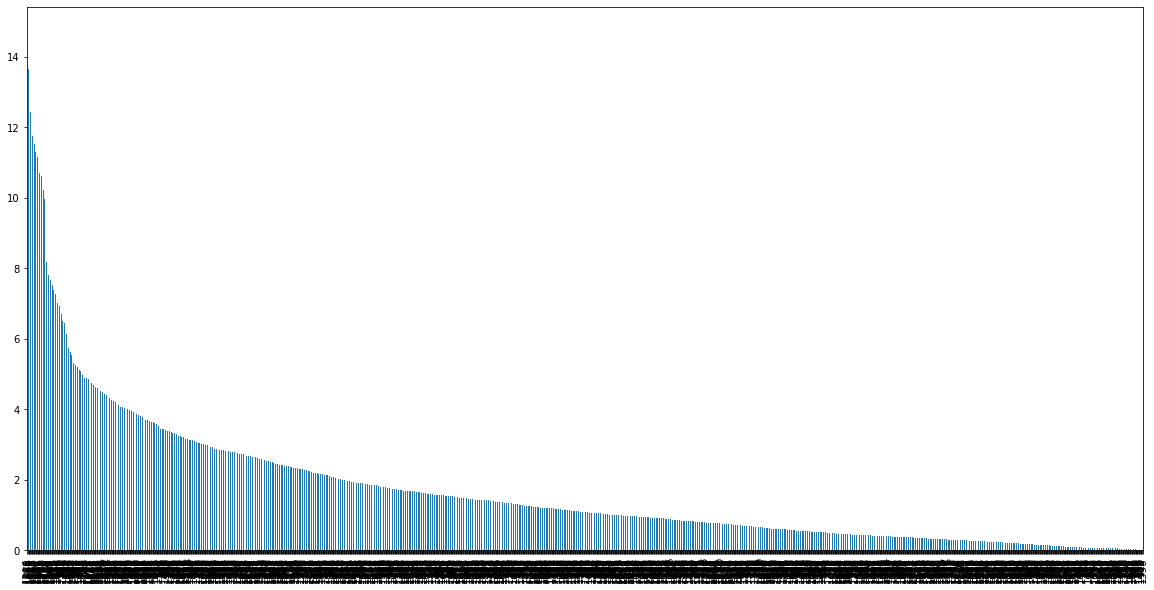

In [14]:
#fi=pd.Series(model.feature_importances_)
fi=pd.Series(fit.scores_)
fi=fi.sort_values(ascending=False)
fi.plot.bar(figsize=(20,10))

In [129]:
import secrets

@ray.remote
def work_log():
    n_tentativi = 20000
    Barre_min = 1
    Barre_max = 6
    N_STRATEGY = 20
    EXIT = random.randrange(Barre_min, Barre_max+1)
    DIREZIONE = "long"
    n_split = random.randrange(100, 200)
    avg_trade_train_min = 150+costi
    avg_trade_test_min = 150+costi
    n_op_train_min = 150
    n_op_test_min = 150
    OOS=5000
    TIME_FRAME=RESAMPLE_TF
    #global history
    tg=target(DIREZIONE,EXIT,history)
    y=tg.T
    #global dataset_ind
    X=dataset_ind.T.values #X2
    DATAFRAME=history

    long_strategy=[]
    short_strategy=[]
    check_OOS_L=[]
    check_OOS_S=[]
    cnt_total=0

    print("PARAMETRI:")
    print("avg_trade_train_min:",avg_trade_train_min)
    print("avg_trade_test_min:",avg_trade_test_min)
    print("n_op_train_min:",n_op_train_min)
    print("n_op_test_min:",n_op_test_min)

    random.seed(a=None, version=2)
    X_dim = range(len(X))

    info_long=[]
    info_short=[]

    while True:

        no_op=0
        cnt=0
        no_rank=0
        n_accettate=0
        while True:
            cnt_total += 1
            cnt += 1
            s=random.sample(X_dim, 5)
            c=X[s[0]]&X[s[1]]&X[s[2]]&X[s[3]]&~X[s[4]]
            m=strategy(c,EXIT,y,0)

            temp_check=m[:-OOS]
            if len(temp_check[temp_check!=0])>=n_op_train_min+n_op_test_min:
                m_split = np.array_split(temp_check ,n_split)
                train = np.concatenate(m_split[0::2])
                test = np.concatenate(m_split[1::2])
                train=train[train!=0]
                test=test[test!=0]
                avg_train=np.sum(train)/len(train)
                avg_test=np.sum(test)/len(test)
                n_accettate += 1
                if (avg_train > avg_trade_train_min)&(len(train)>n_op_train_min)&(avg_test>avg_trade_test_min)&(len(test)>n_op_test_min)&(skew(temp_check)>7)&(len(long_strategy)<N_STRATEGY):
                    long_strategy.append(m)
                    print("Strategia Long N°:",cnt,"generate Uscita:",EXIT,"Split:",n_split)
                    check_OOS_L.append([np.sum(m[:-OOS]),np.sum(m[-OOS:])])
                    info_long.append([s,EXIT])
                    #EXIT = random.randrange(4, 20) 
                    #n_split = random.randrange(50, 150) 
                    #tg=target(DIREZIONE,EXIT,history)
                    #y=tg.T
                    break

                avg_train_r=avg_train*(-1)
                avg_test_r=avg_test*(-1)       
                if (avg_train_r > avg_trade_train_min)&(len(train)>n_op_train_min)&(avg_test_r>avg_trade_test_min)&(len(test)>n_op_test_min)&(skew(temp_check*(-1))>7)&(len(short_strategy)<N_STRATEGY):
                    m=m*(-1)
                    check_OOS_S.append([np.sum(m[:-OOS]),np.sum(m[-OOS:])])
                    short_strategy.append(m)
                    print("Strategia Short N°:",cnt,"generate Uscita:",EXIT,"Split:",n_split)
                    info_short.append([s,EXIT])
                    #EXIT = random.randrange(4, 20) 
                    #n_split = random.randrange(50, 150) 
                    #tg=target(DIREZIONE,EXIT,history)
                    #y=tg.T
                    break   
                else:
                    no_rank += 1
            else:
                no_op += 1

            if cnt == n_tentativi:
                print("Report Generazione:")
                print("Strategie scartate per min op:",no_op,"su",n_tentativi)
                print("Strategie scartate per filtro:",no_rank,"su",n_accettate)
                print("")
                print("RANDOMIZZO EXIT - SPLIT")
                EXIT = random.randrange(Barre_min, Barre_max+1)
                n_split = random.randrange(100, 200) 
                tg=target(DIREZIONE,EXIT,history)
                y=tg.T

                avg_trade_train_min = avg_trade_train_min-10
                avg_trade_test_min = avg_trade_test_min-10
                n_op_train_min = n_op_train_min-10
                n_op_test_min = n_op_test_min-10
                print("NESSUN RISULTATO - UPGRADE PARAMETRI")
                print("avg_trade_train_min:",avg_trade_train_min)
                print("avg_trade_test_min:",avg_trade_test_min)
                print("n_op_train_min:",n_op_train_min)
                print("n_op_test_min:",n_op_test_min)
                break

        if (len(long_strategy)>=N_STRATEGY) & (len(short_strategy)>=N_STRATEGY):
            print("")
            print("############# Fatto ############# GENERATE:",cnt_total,"STRATEGIE")
            break


    ln=pd.DataFrame(long_strategy).T
    ln.index=history.index
    ln.columns = ["long_%d" % i for i,_ in enumerate(ln.columns)]
    ls=pd.DataFrame(short_strategy).T
    ls.index=history.index
    ls.columns = ["short_%d" % i for i,_ in enumerate(ls.columns)]
    
    return ln,ls,info_long,info_short,check_OOS_L,check_OOS_S,cnt_total

In [130]:
from numba import jit
@jit(nopython=True)
def strategy(tmp,exit,target_monetario,costi):
    for el in range(len(tmp)):
        if tmp[el] == 1:
            tmp[el+1:el+exit+1]=0
    d=tmp*target_monetario
    d[d != 0 ]=d[d != 0 ]-costi
    return d

def stampa(lista,title):
    serie=pd.Series(lista)
    serie=serie[serie!=0].dropna()
    serie.cumsum().plot(figsize=(10,10),title=title)
    #for e in idx:
        #plt.axvline(x=e,color="g",alpha=1)
    plt.show()

In [131]:
n_processi =  60 ###### dipende dalla CPU

refs = []
for i in range(n_processi):
    refs.append(work_log.remote())

parallel_returns = ray.get(refs)

2022-12-14 16:06:48,380	WARNING worker.py:1851 -- Warning: The remote function __main__.work_log is very large (16 MiB). Check that its definition is not implicitly capturing a large array or other object in scope. Tip: use ray.put() to put large objects in the Ray object store.


(work_log pid=54100) PARAMETRI:
(work_log pid=54100) avg_trade_train_min: 200
(work_log pid=54100) avg_trade_test_min: 200
(work_log pid=54100) n_op_train_min: 150
(work_log pid=54100) n_op_test_min: 150
(work_log pid=20864) PARAMETRI:
(work_log pid=20864) avg_trade_train_min: 200
(work_log pid=20864) avg_trade_test_min: 200
(work_log pid=20864) n_op_train_min: 150
(work_log pid=20864) n_op_test_min: 150
(work_log pid=10780) PARAMETRI:
(work_log pid=10780) avg_trade_train_min: 200
(work_log pid=10780) avg_trade_test_min: 200
(work_log pid=10780) n_op_train_min: 150
(work_log pid=10780) n_op_test_min: 150
(work_log pid=47020) PARAMETRI:
(work_log pid=47020) avg_trade_train_min: 200
(work_log pid=47020) avg_trade_test_min: 200
(work_log pid=47020) n_op_train_min: 150
(work_log pid=47020) n_op_test_min: 150
(work_log pid=19576) PARAMETRI:
(work_log pid=19576) avg_trade_train_min: 200
(work_log pid=19576) avg_trade_test_min: 200
(work_log pid=19576) n_op_train_min: 150
(work_log pid=19576)

In [132]:
ln=pd.DataFrame()
ls=pd.DataFrame()
LONG_info=pd.DataFrame()
SHORT_info=pd.DataFrame()
check_OOS_L=[]
check_OOS_S=[]
strategie_generate=0
for e in tqdm(range(n_processi)):
    s=parallel_returns[e]
    lng=s[0]
    sht=s[1]
    lng.columns = ["long_gen"+str(e)+"_%d" % i for i,_ in enumerate(lng.columns)]
    sht.columns = ["short_gen"+str(e)+"_%d" % i for i,_ in enumerate(sht.columns)]
    ln=pd.concat([ln,lng],axis=1).fillna(0)
    ls=pd.concat([ls,sht],axis=1).fillna(0)
    long_info=pd.DataFrame(s[2])
    long_info.columns=(["rules_positions","Exit"])
    long_info["direzione"]="long"
    long_info["gen_n"]=str(e)
    long_info["strategy_n"]=list(range(len(long_info)))
    LONG_info=pd.concat([LONG_info,long_info])
    short_info=pd.DataFrame(s[3])
    short_info.columns=(["rules_positions","Exit"])
    short_info["direzione"]="short"
    short_info["gen_n"]=str(e)
    short_info["strategy_n"]=list(range(len(short_info)))
    SHORT_info=pd.concat([SHORT_info,short_info])
    check_OOS_L.extend(s[4])
    check_OOS_S.extend(s[5])
    strategie_generate = strategie_generate+s[6]

  0%|          | 0/60 [00:00<?, ?it/s]

In [133]:
strategie_generate

9423387

In [134]:
ckL=pd.DataFrame(check_OOS_L)
ckL.columns=(["IS","OOS"])
ckL.set_index(["IS"],inplace=True)
ckS=pd.DataFrame(check_OOS_S)
ckS.columns=(["IS","OOS"])
ckS.set_index(["IS"],inplace=True)

In [135]:
from scipy.stats import wilcoxon
res_L = wilcoxon(ckL.iloc[:,0])
res_S = wilcoxon(ckS.iloc[:,0])
res_L , res_S

(WilcoxonResult(statistic=167686.5, pvalue=1.068373749334321e-57),
 WilcoxonResult(statistic=301617.0, pvalue=1.2771397916298205e-06))

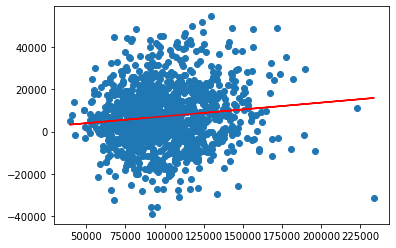

In [136]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
X = ckL.iloc[:,0].index.values.reshape(-1, 1)  # iloc[:, 1] is the column of X
Y = ckL.iloc[:,0].values.reshape(-1, 1)  # df.iloc[:, 4] is the column of Y
linear_regressor = LinearRegression()
linear_regressor.fit(X, Y)
Y_pred = linear_regressor.predict(X)

plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')
plt.show()

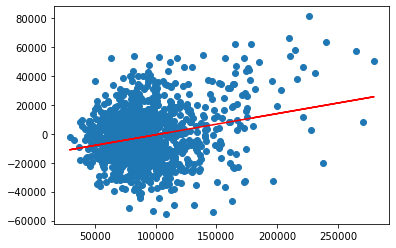

In [137]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
X = ckS.iloc[:,0].index.values.reshape(-1, 1)  # iloc[:, 1] is the column of X
Y = ckS.iloc[:,0].values.reshape(-1, 1)  # df.iloc[:, 4] is the column of Y
linear_regressor = LinearRegression()
linear_regressor.fit(X, Y)
Y_pred = linear_regressor.predict(X)

plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')
plt.show()

In [138]:
####################  CORRELAZIONE LONG 

tmp=ln.iloc[:-OOS].corr()
tmp_s=tmp.sum()
tmp_min=tmp_s.idxmin()
srt=tmp[tmp_min].sort_values()
ok=srt.iloc[:10].index.to_list()
ok.extend([tmp_min])
ln_d=ln[ok]
ln_d.tail()

,long_gen15_0,long_gen0_0,long_gen5_2,long_gen9_6,long_gen27_2,long_gen38_19,long_gen34_14,long_gen17_8,long_gen58_18,long_gen57_7,long_gen1_18
date_time,,,,,,,,,,,
2021-12-30 18:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0
2021-12-30 19:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-12-30 20:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-12-30 21:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-12-30 22:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


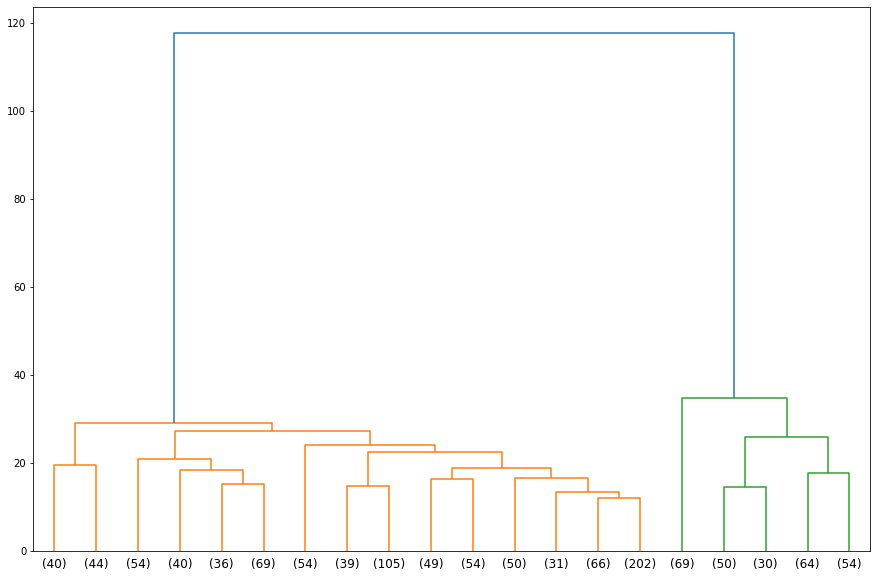


 Cluster 1: N = 40

 Cluster 2: N = 44

 Cluster 3: N = 54

 Cluster 4: N = 40

 Cluster 5: N = 36

 Cluster 6: N = 69

 Cluster 7: N = 54

 Cluster 8: N = 39

 Cluster 9: N = 105

 Cluster 10: N = 49

 Cluster 11: N = 54

 Cluster 12: N = 50

 Cluster 13: N = 31

 Cluster 14: N = 66

 Cluster 15: N = 202

 Cluster 16: N = 69

 Cluster 17: N = 50

 Cluster 18: N = 30

 Cluster 19: N = 64

 Cluster 20: N = 54


  0%|          | 0/20 [00:00<?, ?it/s]

In [155]:
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import ward, fcluster


Z= ln.iloc[:-OOS].corr()  ################  bigdf_PTN_DD sul drawdown oppure bigdf_PTN sulle operazioni

Zlista = Z.index.values.tolist()

linked = linkage(Z, 'ward')

labelList = Zlista

level = 20 ######### numero di cluster 

plt.figure(figsize=(15, 10))
dendro=dendrogram(linked,
            orientation='top',
            labels=labelList,
            distance_sort='Ascending',
            truncate_mode='lastp', 
            show_leaf_counts=True,
            p=level)
plt.show()


label = fcluster(linked, level, criterion='maxclust')

df_clst = pd.DataFrame()
df_clst["index"]  = Z.index
df_clst['label']  = label

LS=[]
for i in range(level):
    elements = df_clst[df_clst['label']==i+1]['index'].tolist()  
    size = len(elements)
    print('\n Cluster {}: N = {}'.format(i+1, size))
    LS.append(elements)


ok=[]
ok2=[]
for idn in tqdm(range(len(LS))):
    v_max=[]
    x=ln[LS[idn]]
    if len(x.columns)>0:
        for k in x.columns:
            g=ln[k].iloc[:-OOS]
            g=g.where(g!=0).dropna()
            p=profit_factor(g)
            k=kestner_ratio(g)
            c=calmar_ratio(g)
            sr=old_sharpe_ratio(g)
            m_var=-np.var(g)
            g=(p+k+c)#*len(g)#*g.sum()

            v_max.append(k) ######## qui metti cosa vuoi valutare

        if len(v_max)>0:
            r=v_max.index(max(v_max))
            ok2.append(max(v_max))
            ok.append(x.iloc[:,r].name)
            
ln_d=ln[ok]

In [139]:
####################  CORRELAZIONE SHORT

tmp=ls.iloc[:-OOS].corr()
tmp_s=tmp.sum()
tmp_min=tmp_s.idxmin()
srt=tmp[tmp_min].sort_values()
ok=srt.iloc[:10].index.to_list()
ok.extend([tmp_min])
ls_d=ls[ok]
ls_d.tail()

,short_gen4_4,short_gen41_6,short_gen27_14,short_gen11_2,short_gen41_11,short_gen48_16,short_gen59_10,short_gen38_5,short_gen17_19,short_gen21_6,short_gen57_17
date_time,,,,,,,,,,,
2021-12-30 18:00:00,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
2021-12-30 19:00:00,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
2021-12-30 20:00:00,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
2021-12-30 21:00:00,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
2021-12-30 22:00:00,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0


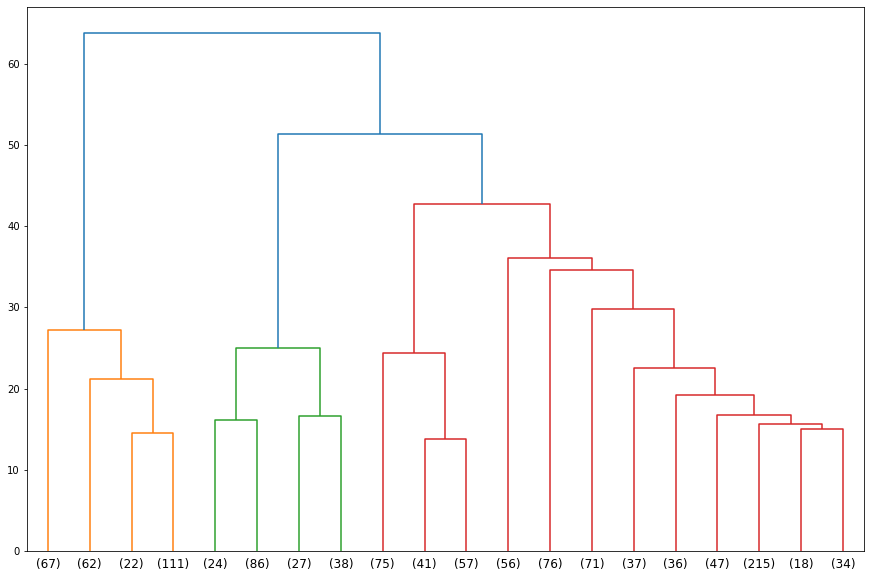


 Cluster 1: N = 67

 Cluster 2: N = 62

 Cluster 3: N = 22

 Cluster 4: N = 111

 Cluster 5: N = 24

 Cluster 6: N = 86

 Cluster 7: N = 27

 Cluster 8: N = 38

 Cluster 9: N = 75

 Cluster 10: N = 41

 Cluster 11: N = 57

 Cluster 12: N = 56

 Cluster 13: N = 76

 Cluster 14: N = 71

 Cluster 15: N = 37

 Cluster 16: N = 36

 Cluster 17: N = 47

 Cluster 18: N = 215

 Cluster 19: N = 18

 Cluster 20: N = 34


  0%|          | 0/20 [00:00<?, ?it/s]

In [156]:
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import ward, fcluster


Z= ls.iloc[:-OOS].corr()  ################  bigdf_PTN_DD sul drawdown oppure bigdf_PTN sulle operazioni

Zlista = Z.index.values.tolist()

linked = linkage(Z, 'ward')

labelList = Zlista

level = 20 ######### numero di cluster 

plt.figure(figsize=(15, 10))
dendro=dendrogram(linked,
            orientation='top',
            labels=labelList,
            distance_sort='Ascending',
            truncate_mode='lastp', 
            show_leaf_counts=True,
            p=level)
plt.show()


label = fcluster(linked, level, criterion='maxclust')

df_clst = pd.DataFrame()
df_clst["index"]  = Z.index
df_clst['label']  = label

LS=[]
for i in range(level):
    elements = df_clst[df_clst['label']==i+1]['index'].tolist()  
    size = len(elements)
    print('\n Cluster {}: N = {}'.format(i+1, size))
    LS.append(elements)


ok=[]
ok2=[]
for idn in tqdm(range(len(LS))):
    v_max=[]
    x=ls[LS[idn]]
    if len(x.columns)>0:
        for k in x.columns:
            g=ls[k].iloc[:-OOS]
            g=g.where(g!=0).dropna()
            p=profit_factor(g)
            k=kestner_ratio(g)
            c=calmar_ratio(g)
            sr=old_sharpe_ratio(g)
            m_var=-np.var(g)
            g=(p+k+c)#*len(g)#*g.sum()

            v_max.append(k) ######## qui metti cosa vuoi valutare

        if len(v_max)>0:
            r=v_max.index(max(v_max))
            ok2.append(max(v_max))
            ok.append(x.iloc[:,r].name)
ls_d=ls[ok]

print(m.std(),skew(m))

for e in range(0,len(y)-OOS,len(m_split[0])):
    plt.axvline(x=e,color="g",alpha=1)
plt.axvline(x=len(y)-OOS,color="r",alpha=1)
stampa(m,"Full "+DIREZIONE)

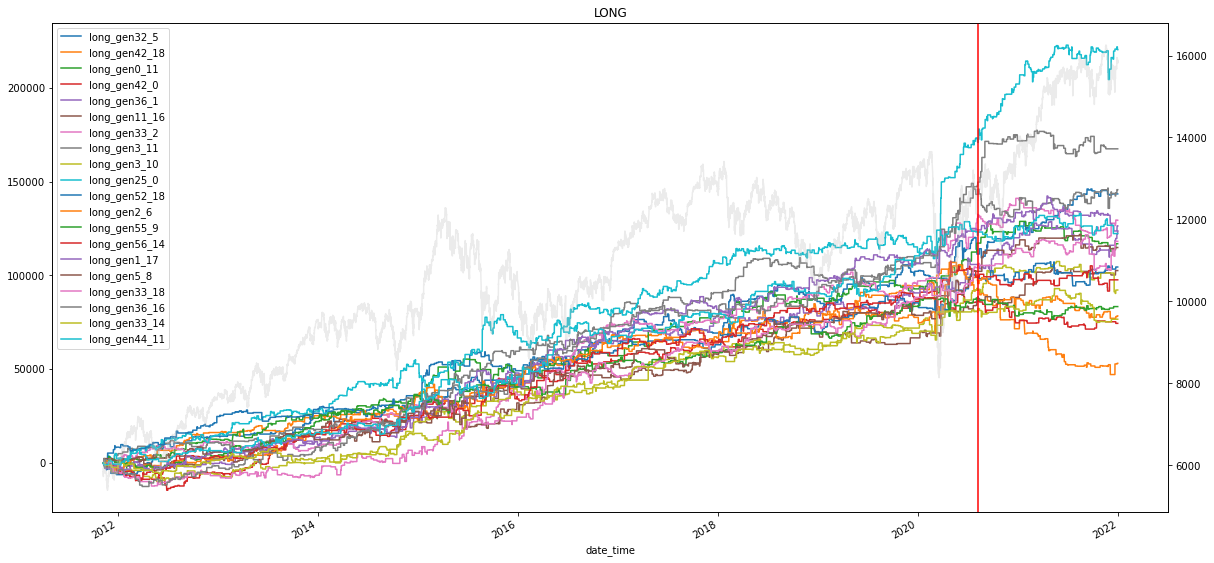

In [157]:
ln_d.cumsum().plot(figsize=(20,10),title="LONG")
history.close.plot(secondary_y=True , color="silver", alpha=0.3)
plt.axvline(x=dataset.iloc[len(dataset)-OOS].name,color="r",alpha=1)
#plt.axvline(x=ln.iloc[len(y)-4000].name,color="r",alpha=1)

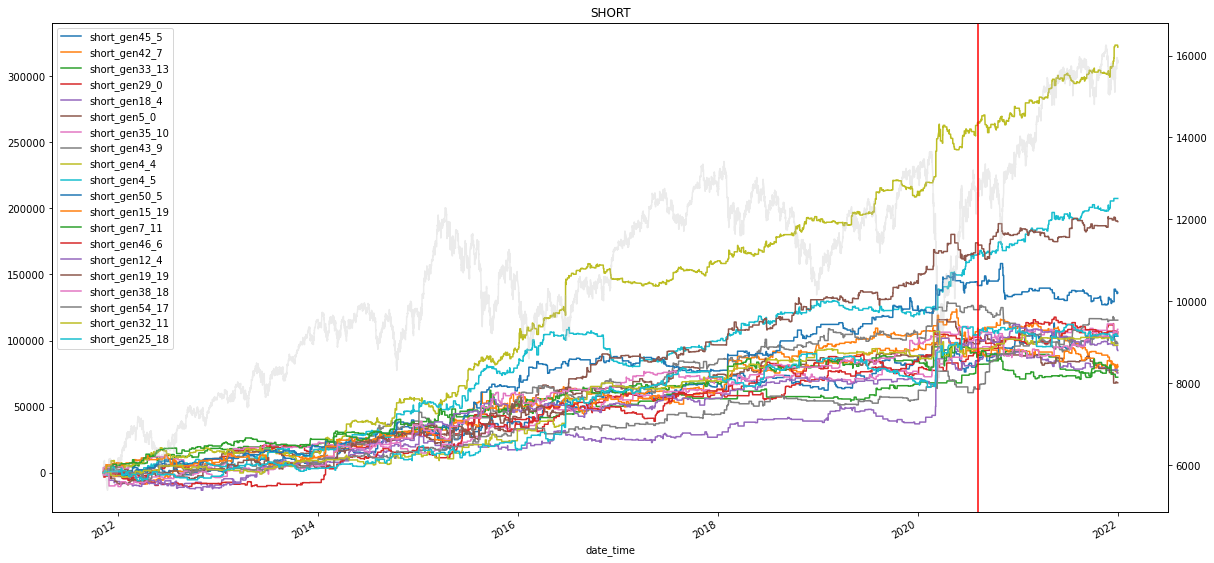

In [158]:
ls_d.cumsum().plot(figsize=(20,10),title="SHORT")
history.close.plot(secondary_y=True , color="silver", alpha=0.3)
plt.axvline(x=dataset.iloc[len(dataset)-OOS].name,color="r",alpha=1)
#plt.axvline(x=ln.iloc[len(y)-4000].name,color="r",alpha=1)

In [162]:
newdf = pd.concat([ln_d,ls_d],axis=1).fillna(0)
w=newdf.iloc[:-1].std()
w=w.to_frame()#.round()
w.columns=(["STD"])
w["weigh"]=w.STD.max()
w["app"]=(w.weigh/w.STD).round(2)
w

,STD,weigh,app
long_gen32_5,197.937467,351.223301,1.77
long_gen42_18,208.428188,351.223301,1.69
long_gen0_11,186.999749,351.223301,1.88
long_gen42_0,173.699553,351.223301,2.02
long_gen36_1,192.297659,351.223301,1.83
long_gen11_16,164.880203,351.223301,2.13
long_gen33_2,207.873783,351.223301,1.69
long_gen3_11,207.725500,351.223301,1.69
long_gen3_10,160.203373,351.223301,2.19
long_gen25_0,268.708477,351.223301,1.31


In [159]:
ptf=pd.concat([ln_d,ls_d],axis=1)

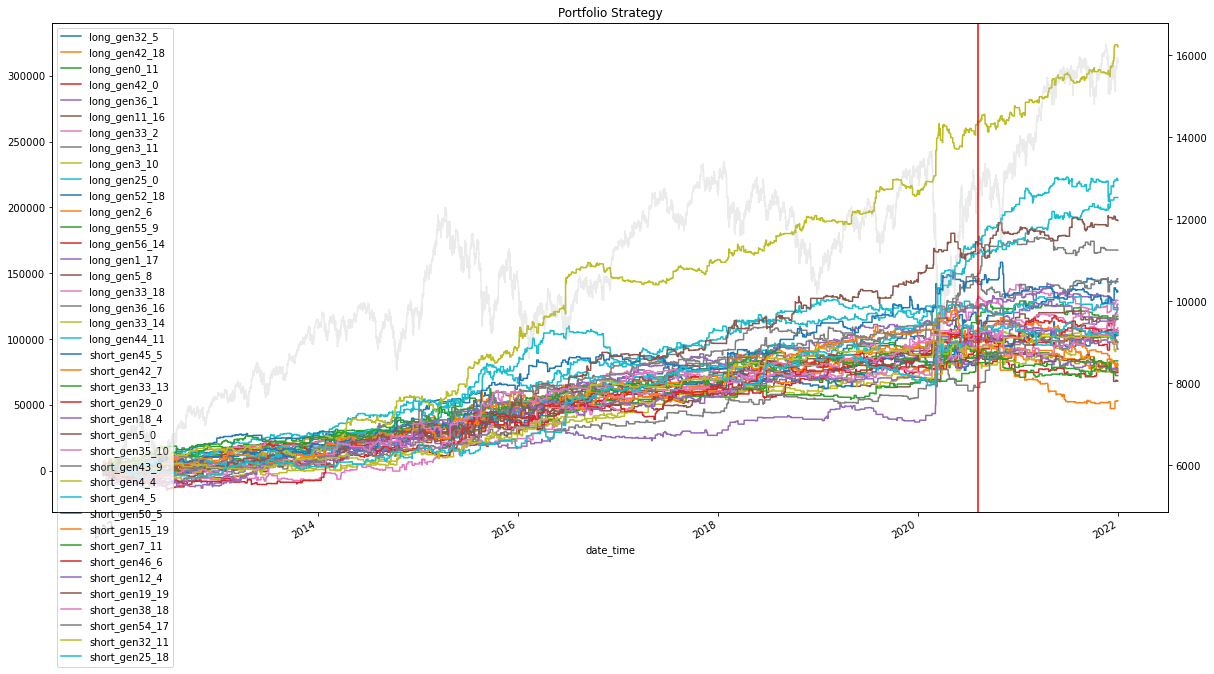

In [160]:
ptf.cumsum().plot(figsize=(20,10),title="Portfolio Strategy")
history.close.plot(secondary_y=True , color="silver", alpha=0.3)
plt.axvline(x=dataset.iloc[len(dataset)-OOS].name,color="r",alpha=1)
#plt.axvline(x=ln.iloc[len(y)-4000].name,color="r",alpha=1)

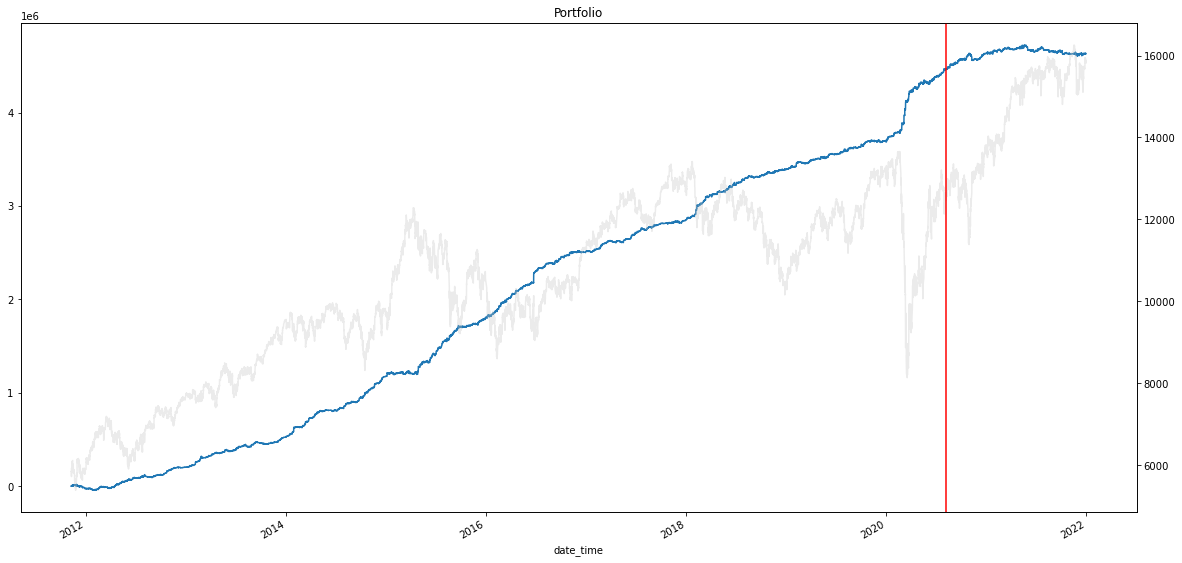

In [161]:
ptf.sum(axis=1).cumsum().plot(figsize=(20,10),title="Portfolio")
history.close.plot(secondary_y=True , color="silver", alpha=0.3)
plt.axvline(x=dataset.iloc[len(dataset)-OOS].name,color="r",alpha=1)

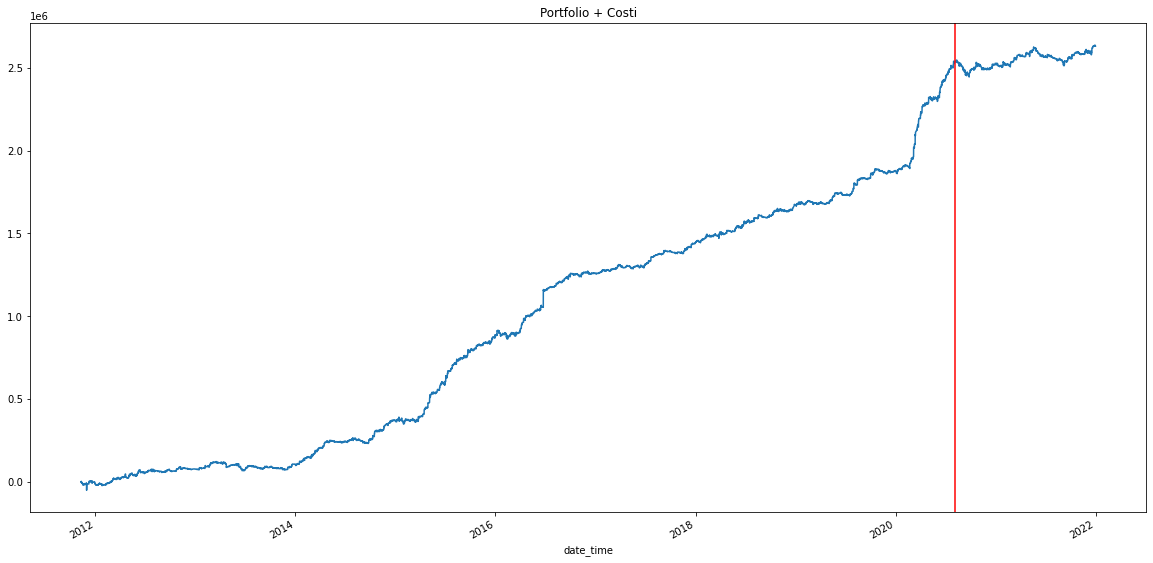

In [146]:
ptf[ptf!=0]=ptf[ptf!=0]-costi

ptf.sum(axis=1).cumsum().plot(figsize=(20,10),title="Portfolio + Costi")
plt.axvline(x=dataset.iloc[len(dataset)-OOS].name,color="r",alpha=1)

In [147]:
ptf=ptf.loc[~(ptf==0).all(axis=1)]

ptf.corr()

,long_gen15_0,long_gen0_0,long_gen5_2,long_gen9_6,long_gen27_2,long_gen38_19,long_gen34_14,long_gen17_8,long_gen58_18,long_gen57_7,...,short_gen41_6,short_gen27_14,short_gen11_2,short_gen41_11,short_gen48_16,short_gen59_10,short_gen38_5,short_gen17_19,short_gen21_6,short_gen57_17
long_gen15_0,1.000000,0.023483,0.472486,-0.000913,0.004236,0.048124,-0.020695,0.068325,0.016221,0.059007,...,-0.001343,-0.001193,-0.019432,-0.001015,-0.011075,-0.001269,-0.008886,-0.026666,-0.014946,-0.000456
long_gen0_0,0.023483,1.000000,0.029092,-0.001226,0.015758,0.023503,0.050097,0.540652,0.001332,0.027772,...,-0.003284,-0.006311,-0.008145,-0.005897,-0.027318,-0.002859,-0.005984,-0.035296,-0.003187,-0.000612
long_gen5_2,0.472486,0.029092,1.000000,0.001392,-0.000748,0.125471,0.127976,0.029100,0.012916,0.162421,...,-0.000913,-0.000952,-0.029803,-0.000643,-0.014079,-0.001013,-0.002052,-0.035846,-0.000727,-0.000363
long_gen9_6,-0.000913,-0.001226,0.001392,1.000000,-0.001169,-0.001260,0.014266,-0.001160,0.037851,-0.000869,...,-0.001404,-0.001273,-0.002289,-0.001004,-0.010956,-0.001364,-0.001245,-0.020437,-0.001135,-0.000567
long_gen27_2,0.004236,0.015758,-0.000748,-0.001169,1.000000,0.004569,0.076098,0.000558,-0.000340,0.002759,...,-0.001445,-0.001310,-0.001702,-0.004315,-0.001655,-0.001404,-0.001282,-0.001620,-0.001169,-0.000584
long_gen38_19,0.048124,0.023503,0.125471,-0.001260,0.004569,1.000000,0.010622,0.024460,0.002050,0.619924,...,-0.001557,-0.001411,-0.014498,-0.001114,-0.010339,-0.001513,-0.001381,-0.027910,-0.001259,-0.000629
long_gen34_14,-0.020695,0.050097,0.127976,0.014266,0.076098,0.010622,1.000000,0.017086,0.001612,0.018276,...,-0.004404,-0.006540,-0.002945,-0.004950,-0.009869,-0.008620,-0.003790,-0.011295,-0.004680,-0.000579
long_gen17_8,0.068325,0.540652,0.029100,-0.001160,0.000558,0.024460,0.017086,1.000000,-0.000338,0.040995,...,-0.001433,-0.001299,-0.013515,-0.001025,-0.044939,-0.001393,-0.001271,-0.049242,-0.001159,-0.000579
long_gen58_18,0.016221,0.001332,0.012916,0.037851,-0.000340,0.002050,0.001612,-0.000338,1.000000,-0.000253,...,-0.029088,-0.060417,-0.000482,-0.048564,-0.000437,-0.044020,-0.039929,-0.000459,-0.028361,-0.005856
long_gen57_7,0.059007,0.027772,0.162421,-0.000869,0.002759,0.619924,0.018276,0.040995,-0.000253,1.000000,...,-0.001074,-0.000973,-0.017043,-0.000993,-0.010314,-0.001043,-0.000952,-0.028506,-0.000868,-0.000434


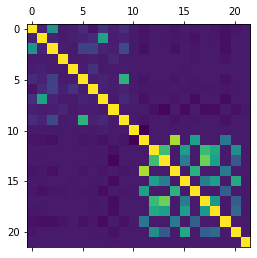

In [148]:
plt.matshow(ptf.corr())
plt.show()

In [149]:
for e in ptf.columns:
    x=ptf[e]
    x=x[x!=0]
    k=performance_report_gen(x)
    k["nome"]=e
    display(k)

,Profit,MaxDD,Operations,AverageTrade,ProfitFactor,PctWin,KestnerRatio,STD_Daily,Skew,Reward_Risk_Ratio,nome
0,83975.0,-17025.0,434,193.49,1.35,55.99,0.33,630.269129,0.182247,1.06,long_gen15_0


,Profit,MaxDD,Operations,AverageTrade,ProfitFactor,PctWin,KestnerRatio,STD_Daily,Skew,Reward_Risk_Ratio,nome
0,129100.0,-16000.0,541,238.63,1.41,52.31,0.26,725.5286,0.457371,1.28,long_gen0_0


,Profit,MaxDD,Operations,AverageTrade,ProfitFactor,PctWin,KestnerRatio,STD_Daily,Skew,Reward_Risk_Ratio,nome
0,60000.0,-13225.0,412,145.63,1.28,53.64,0.16,569.512326,0.929761,1.1,long_gen5_2


,Profit,MaxDD,Operations,AverageTrade,ProfitFactor,PctWin,KestnerRatio,STD_Daily,Skew,Reward_Risk_Ratio,nome
0,93200.0,-20175.0,345,270.14,1.51,57.1,0.32,565.130709,0.7983,1.13,long_gen9_6


,Profit,MaxDD,Operations,AverageTrade,ProfitFactor,PctWin,KestnerRatio,STD_Daily,Skew,Reward_Risk_Ratio,nome
0,93200.0,-15025.0,396,235.35,1.49,57.83,0.36,543.98198,0.649551,1.09,long_gen27_2


,Profit,MaxDD,Operations,AverageTrade,ProfitFactor,PctWin,KestnerRatio,STD_Daily,Skew,Reward_Risk_Ratio,nome
0,165725.0,-24725.0,713,232.43,1.39,56.38,0.25,901.237028,0.339414,1.08,long_gen38_19


,Profit,MaxDD,Operations,AverageTrade,ProfitFactor,PctWin,KestnerRatio,STD_Daily,Skew,Reward_Risk_Ratio,nome
0,84150.0,-14850.0,383,219.71,1.53,52.48,0.47,509.207259,1.438709,1.38,long_gen34_14


,Profit,MaxDD,Operations,AverageTrade,ProfitFactor,PctWin,KestnerRatio,STD_Daily,Skew,Reward_Risk_Ratio,nome
0,115600.0,-16875.0,476,242.86,1.42,52.73,0.43,686.053928,0.605893,1.28,long_gen17_8


,Profit,MaxDD,Operations,AverageTrade,ProfitFactor,PctWin,KestnerRatio,STD_Daily,Skew,Reward_Risk_Ratio,nome
0,30775.0,-20650.0,348,88.43,1.13,52.3,0.15,643.893236,0.719364,1.03,long_gen58_18


,Profit,MaxDD,Operations,AverageTrade,ProfitFactor,PctWin,KestnerRatio,STD_Daily,Skew,Reward_Risk_Ratio,nome
0,75175.0,-12375.0,562,133.76,1.28,53.38,0.24,584.460955,0.349399,1.12,long_gen57_7


,Profit,MaxDD,Operations,AverageTrade,ProfitFactor,PctWin,KestnerRatio,STD_Daily,Skew,Reward_Risk_Ratio,nome
0,46875.0,-9700.0,337,139.09,1.42,58.16,0.27,350.774594,0.302563,1.02,long_gen1_18


,Profit,MaxDD,Operations,AverageTrade,ProfitFactor,PctWin,KestnerRatio,STD_Daily,Skew,Reward_Risk_Ratio,nome
0,262300.0,-34300.0,1183,221.72,1.46,50.97,0.44,1068.701222,3.110326,1.4,short_gen4_4


,Profit,MaxDD,Operations,AverageTrade,ProfitFactor,PctWin,KestnerRatio,STD_Daily,Skew,Reward_Risk_Ratio,nome
0,148825.0,-16650.0,558,266.71,1.52,52.51,0.46,726.363518,0.562905,1.37,short_gen41_6


,Profit,MaxDD,Operations,AverageTrade,ProfitFactor,PctWin,KestnerRatio,STD_Daily,Skew,Reward_Risk_Ratio,nome
0,100800.0,-13450.0,400,252.0,1.54,55.5,0.39,551.828037,0.277328,1.24,short_gen27_14


,Profit,MaxDD,Operations,AverageTrade,ProfitFactor,PctWin,KestnerRatio,STD_Daily,Skew,Reward_Risk_Ratio,nome
0,230125.0,-34100.0,846,272.02,1.58,52.01,0.41,960.957669,3.719232,1.45,short_gen11_2


,Profit,MaxDD,Operations,AverageTrade,ProfitFactor,PctWin,KestnerRatio,STD_Daily,Skew,Reward_Risk_Ratio,nome
0,111225.0,-22600.0,587,189.48,1.33,51.96,0.3,764.200691,-0.066873,1.23,short_gen41_11


,Profit,MaxDD,Operations,AverageTrade,ProfitFactor,PctWin,KestnerRatio,STD_Daily,Skew,Reward_Risk_Ratio,nome
0,227150.0,-31900.0,909,249.89,1.5,51.16,0.25,1045.541747,3.785321,1.43,short_gen48_16


,Profit,MaxDD,Operations,AverageTrade,ProfitFactor,PctWin,KestnerRatio,STD_Daily,Skew,Reward_Risk_Ratio,nome
0,106400.0,-13450.0,375,283.73,1.62,54.67,0.44,538.145649,0.285115,1.35,short_gen59_10


,Profit,MaxDD,Operations,AverageTrade,ProfitFactor,PctWin,KestnerRatio,STD_Daily,Skew,Reward_Risk_Ratio,nome
0,139425.0,-16650.0,593,235.12,1.41,52.95,0.35,764.250839,0.331729,1.26,short_gen38_5


,Profit,MaxDD,Operations,AverageTrade,ProfitFactor,PctWin,KestnerRatio,STD_Daily,Skew,Reward_Risk_Ratio,nome
0,191475.0,-21900.0,470,407.39,1.69,50.64,0.18,855.382443,1.740365,1.65,short_gen17_19


,Profit,MaxDD,Operations,AverageTrade,ProfitFactor,PctWin,KestnerRatio,STD_Daily,Skew,Reward_Risk_Ratio,nome
0,101600.0,-14950.0,400,254.0,1.48,51.75,0.36,613.290454,0.762408,1.38,short_gen21_6


,Profit,MaxDD,Operations,AverageTrade,ProfitFactor,PctWin,KestnerRatio,STD_Daily,Skew,Reward_Risk_Ratio,nome
0,33925.0,-7950.0,290,116.98,1.23,53.45,0.29,412.967608,0.505797,1.07,short_gen57_17


In [150]:
LONG_info["nome"]=LONG_info["direzione"]+"_gen"+LONG_info["gen_n"].astype(str)+"_"+LONG_info["strategy_n"].astype(str)
LONG_info.tail()

,rules_positions,Exit,direzione,gen_n,strategy_n,nome
15,"[11, 274, 100, 95, 81]",5,long,59,15,long_gen59_15
16,"[230, 150, 232, 176, 271]",5,long,59,16,long_gen59_16
17,"[85, 11, 13, 19, 72]",5,long,59,17,long_gen59_17
18,"[160, 164, 21, 7, 33]",5,long,59,18,long_gen59_18
19,"[156, 209, 119, 91, 28]",5,long,59,19,long_gen59_19


In [151]:
SHORT_info["nome"]=SHORT_info["direzione"]+"_gen"+SHORT_info["gen_n"].astype(str)+"_"+SHORT_info["strategy_n"].astype(str)
SHORT_info.tail()

,rules_positions,Exit,direzione,gen_n,strategy_n,nome
15,"[115, 33, 144, 173, 103]",6,short,59,15,short_gen59_15
16,"[148, 240, 144, 289, 116]",6,short,59,16,short_gen59_16
17,"[183, 86, 263, 271, 118]",6,short,59,17,short_gen59_17
18,"[125, 209, 74, 223, 225]",6,short,59,18,short_gen59_18
19,"[110, 67, 203, 141, 181]",6,short,59,19,short_gen59_19


In [152]:
csv_export=pd.DataFrame()

for e in ln_d.columns:
    
    long_info=LONG_info[LONG_info.nome==e]
    s = long_info.rules_positions.values[0]
    Exit = long_info.Exit.values[0]
    direzione = long_info.direzione.values[0]
    string_rule = "("+rules_name[s[0]]+")&("+rules_name[s[1]]+")&("+rules_name[s[2]]+")&("+rules_name[s[3]]+")&~("+rules_name[s[4]]+")"

    level="history.close"
    ADD_RULE_CONDITION="False"
    tipo_ordine="market"
    
    info=pd.DataFrame()
    info=pd.DataFrame([bigpointvalue,tick,SIMBOLO,utc_offset,TYPE_SESSION,RESAMPLE_TF,START_DATE,END_DATE,str(custom_session_start),str(custom_session_stop),costi,direzione,tipo_ordine,string_rule,Exit,level,ADD_RULE_CONDITION]).T  
    info.columns=(["bigpointvalue","tick","file_name","uct_offset","type_session","resample_tf","start_date","end_date","custom_session_start","custom_session_stop","costi","direzione","tipo_ordine","entry_rules","exit_bars","level","ADD_RULE_CONDITION"])
    csv_export=pd.concat([csv_export,info])

    
for e in ls_d.columns:
    
    short_info=SHORT_info[SHORT_info.nome==e]
    s = short_info.rules_positions.values[0]
    Exit = short_info.Exit.values[0]
    direzione = short_info.direzione.values[0]
    string_rule = "("+rules_name[s[0]]+")&("+rules_name[s[1]]+")&("+rules_name[s[2]]+")&("+rules_name[s[3]]+")&~("+rules_name[s[4]]+")"

    level="history.close"
    ADD_RULE_CONDITION="False"
    tipo_ordine="market"
    
    info=pd.DataFrame()
    info=pd.DataFrame([bigpointvalue,tick,SIMBOLO,utc_offset,TYPE_SESSION,RESAMPLE_TF,START_DATE,END_DATE,str(custom_session_start),str(custom_session_stop),costi,direzione,tipo_ordine,string_rule,Exit,level,ADD_RULE_CONDITION]).T  
    info.columns=(["bigpointvalue","tick","file_name","uct_offset","type_session","resample_tf","start_date","end_date","custom_session_start","custom_session_stop","costi","direzione","tipo_ordine","entry_rules","exit_bars","level","ADD_RULE_CONDITION"])
    csv_export=pd.concat([csv_export,info]) 

In [153]:
csv_export

,bigpointvalue,tick,file_name,uct_offset,type_session,resample_tf,start_date,end_date,custom_session_start,custom_session_stop,costi,direzione,tipo_ordine,entry_rules,exit_bars,level,ADD_RULE_CONDITION
0,25,0.5,FDAX,CET,1,60min,2010-01-01,2022-01-01,0800,2200,50,long,market,(HighToCloseLog(DATAFRAME).shift(1)>(HighToClo...,6,history.close,False
0,25,0.5,FDAX,CET,1,60min,2010-01-01,2022-01-01,0800,2200,50,long,market,(RangeLog(DATAFRAME).shift(1)>(RangeLog(DATAFR...,6,history.close,False
0,25,0.5,FDAX,CET,1,60min,2010-01-01,2022-01-01,0800,2200,50,long,market,(RangeLog(DATAFRAME).shift(1)<(RangeLog(DATAFR...,5,history.close,False
0,25,0.5,FDAX,CET,1,60min,2010-01-01,2022-01-01,0800,2200,50,long,market,(HighToHighLog(DATAFRAME).shift(1)<(HighToHigh...,6,history.close,False
0,25,0.5,FDAX,CET,1,60min,2010-01-01,2022-01-01,0800,2200,50,long,market,(OpenToLowLog(DATAFRAME).shift(1)<(OpenToLowLo...,5,history.close,False
0,25,0.5,FDAX,CET,1,60min,2010-01-01,2022-01-01,0800,2200,50,long,market,(HighToMedPriceLog(DATAFRAME).shift(1)<(HighTo...,6,history.close,False
0,25,0.5,FDAX,CET,1,60min,2010-01-01,2022-01-01,0800,2200,50,long,market,(HighToHighLog(DATAFRAME).shift(1)<(HighToHigh...,4,history.close,False
0,25,0.5,FDAX,CET,1,60min,2010-01-01,2022-01-01,0800,2200,50,long,market,(HighToHighLog(DATAFRAME).shift(1)<(HighToHigh...,6,history.close,False
0,25,0.5,FDAX,CET,1,60min,2010-01-01,2022-01-01,0800,2200,50,long,market,(OpenToLowLog(DATAFRAME).shift(1)>(OpenToLowLo...,6,history.close,False
0,25,0.5,FDAX,CET,1,60min,2010-01-01,2022-01-01,0800,2200,50,long,market,(MedBodyPriceToLowLog(DATAFRAME).shift(1)<(Med...,4,history.close,False


In [154]:
os.chdir(r"C:\Users\Drako\Genetico_V3\Strategie_LS")

import uuid

idz = uuid.uuid1()
save_as = SIMBOLO+"_system_"+RESAMPLE_TF+"_"+str(idz)+".csv"
csv_export.to_csv(save_as)

In [95]:
def faster_supertrend_talib(high, low, close, period=7, multiplier=3):
    avg_price = talib.MEDPRICE(high, low)
    atr = talib.ATR(high, low, close, period)
    upper, lower = get_basic_bands(avg_price, atr, multiplier)
    return get_final_bands_nb(close, upper, lower)



array([ 1,  1,  1, ..., -1, -1, -1], dtype=int64)

In [111]:
v1=np.arange(0.5,10,0.5)
v2=np.arange(5,50,1)

ls=[]

for t in tqdm(v1):
    for r in tqdm(v2):
        st=faster_supertrend_talib(history.high.values, history.low.values, history.close.values, period=r, multiplier=t)[1]

        newdf=pd.DataFrame()
        for e in range(len(ptf.columns)):
            a=ptf.iloc[:,e].to_frame()
            a["st"]=st
            a["st"]=a["st"].shift(1)
            a["nb"]=0
            if "long" in ptf.iloc[:,e].name:
                direz=1
            else:
                direz=-1
            a["nb"]=np.where(a.st==direz,a.iloc[:,0],a.nb)
            newdf=pd.concat([newdf,a.nb],axis=1).fillna(0)
            
        ls.append([newdf.sum(axis=1).loc[dataset.iloc[len(dataset)-OOS].name:].sum(),t,r])

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

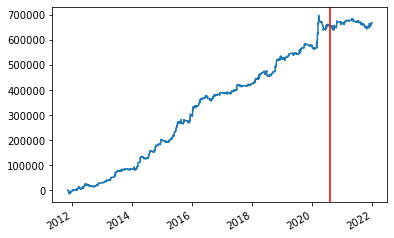

In [97]:

newdf.sum(axis=1).loc[dataset.iloc[len(dataset)-OOS].name:].sum()


In [112]:
res=pd.DataFrame(ls)
res.columns=(["pnl","V2","V1"])
res=res.sort_values(by="pnl",ascending=False)
res.head()

,pnl,V2,V1
130,76375.0,1.5,45
129,76375.0,1.5,44
128,76000.0,1.5,43
127,76000.0,1.5,42
131,75400.0,1.5,46


In [163]:

st=faster_supertrend_talib(history.high.values, history.low.values, history.close.values, period=45, multiplier=1.5)[1]

newdf=pd.DataFrame()
for e in range(len(ptf.columns)):
    a=ptf.iloc[:,e].to_frame()
    a["st"]=st
    a["st"]=a["st"].shift(1)
    a["nb"]=0
    if "long" in ptf.iloc[:,e].name:
        direz=1
    else:
        direz=-1
    a["nb"]=np.where(a.st==direz,a.iloc[:,0],a.nb)
    newdf=pd.concat([newdf,a.nb],axis=1).fillna(0)


<AxesSubplot:>

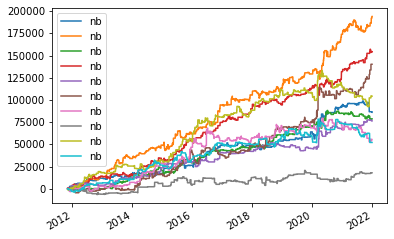

In [117]:

newdf.cumsum().plot()


<AxesSubplot:>

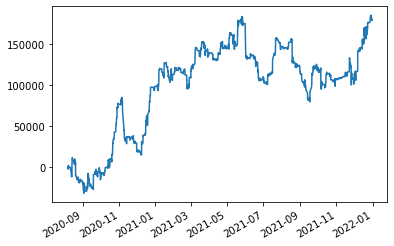

In [166]:
#ptf.sum(axis=1).cumsum().plot()
newdf.loc[dataset.iloc[len(dataset)-OOS].name:].sum(axis=1).cumsum().plot()


<AxesSubplot:xlabel='date_time'>

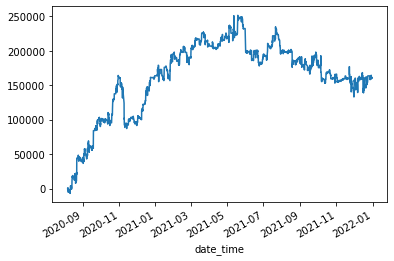

In [167]:
ptf.loc[dataset.iloc[len(dataset)-OOS].name:].sum(axis=1).cumsum().plot()